# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

if False:
    helper.download_extract('mnist', data_dir)
    helper.download_extract('celeba', data_dir)

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

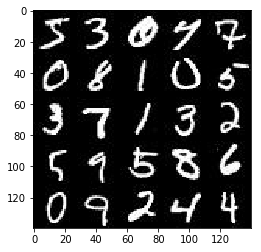

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

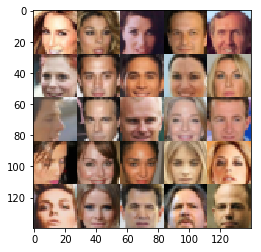

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name = 'input_z')
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [27]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # Peronsal Notes:
    # The last layer of the generator and first layer of the discriminator are not batch normalized, 
    # so that the model can learn the correct mean and scale of the data distribution.'''
    
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse = reuse):
        # Input layers is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides = 2, padding = 'same')
        x2 = tf.layers.batch_normalization(x2, training = True)
        relu2 = tf.maximum(alpha * x2, x2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides = 2, padding = 'same')
        x3 = tf.layers.batch_normalization(x3, training = True)
        relu3 = tf.maximum(alpha * x3, x3)
        # 4x4x256
        
        #x4 = tf.layers.conv2d(relu3, 512, 5, strides = 2, padding = 'same')
        #x4 = tf.layers.batch_normalization(x4, training = not reuse)
        #relu4 = tf.maximum(alpha * x4, x4)
        # 2x2x512
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        #flat = tf.reshape(relu4, (-1, 2*2*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [28]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse = not is_train):
        # 1st layers
        if False:
            x1 = tf.layers.dense(z, 2 * 2 * 1024)
            # Reshape to start the Convlutional stack
            x1 = tf.reshape(x1, (-1, 2, 2, 1024))
            x1 = tf.layers.batch_normalization(x1, training = is_train)
            x1 = tf.maximum(alpha * x1, x1)
            # 2x2x1024
            #print(x1)

            # 2nd layer 
            x2 = tf.layers.conv2d_transpose(x1, 512, 5, strides = 2, padding = 'same') 
            x2 = tf.layers.batch_normalization(x2, training = is_train)
            x2 = tf.maximum(alpha * x2, x2)
            # 4x4x512
            #print(x2)
        else:
            x2 = tf.layers.dense(z, 4 * 4 * 512)
            # Reshape to start the Convlutional stack
            x2 = tf.reshape(x2, (-1, 4, 4, 512))
            x2 = tf.layers.batch_normalization(x2, training = is_train)
            x2 = tf.maximum(alpha * x2, x2)
            # 2x2x1024
            #print(x1)
            
        # 3rd layer
        x3 = tf.layers.conv2d_transpose(x2, 256, 4, strides = 1, padding = 'valid')
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 7x7x256
        #print(x3)
        
        # 4th layers
        x4 = tf.layers.conv2d_transpose(x3, 128, 5, strides = 2, padding = 'same')
        x4 = tf.layers.batch_normalization(x4, training = is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # 14x14x128
        #print(x4)
        
        # 5th layers
        x5 = tf.layers.conv2d_transpose(x4, 128, 5, strides = 2, padding = 'same')
        x5 = tf.layers.batch_normalization(x5, training = is_train)
        x5 = tf.maximum(alpha * x5, x5)
        # 28x28x128
        #print(x5)        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x5, out_channel_dim, 5, strides = 1, padding = 'same')
        # 28x28x3
        #print(logits)
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [29]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, False)
    d_model_fake, d_logits_fake = discriminator(g_model, True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels = tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels = tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels = tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [30]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [31]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [32]:
def train(epoch_count, batch_size, z_dim, learning_rate_value, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # Peronal Note: Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.
    inputs_real, inputs_z, learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    saver = tf.train.Saver(var_list = tf.trainable_variables())
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                   
                batch_images = batch_images * 2
                batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size = (batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict = {inputs_real: batch_images, inputs_z: batch_z, learning_rate: learning_rate_value})
                _ = sess.run(g_opt, feed_dict = {inputs_real: batch_images, inputs_z: batch_z, learning_rate: learning_rate_value})
                
                # For printing
                if steps % 10 == 0:
                    train_loss_d = sess.run(d_loss, feed_dict = {inputs_real: batch_images, inputs_z: batch_z})
                    train_loss_g = sess.run(g_loss, feed_dict = {inputs_z: batch_z})
                    
                    print('Epoch %d/%d, D_loss: %6.4f, G_loss: %6.4f' % (epoch_i, epoch_count, train_loss_d, train_loss_g))
                    
                # For showing generated faces
                if steps % 100 == 0:
                    show_generator_output(sess, 25, inputs_z, data_shape[3], data_image_mode)
                
        saver.save(sess, './whole_model.ckpt')
        

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2, D_loss: 5.3824, G_loss: 0.0054
Epoch 0/2, D_loss: 5.7420, G_loss: 0.0059
Epoch 0/2, D_loss: 0.1253, G_loss: 2.8860
Epoch 0/2, D_loss: 2.8556, G_loss: 11.0872
Epoch 0/2, D_loss: 1.4480, G_loss: 3.3788
Epoch 0/2, D_loss: 1.8960, G_loss: 2.1650
Epoch 0/2, D_loss: 1.7662, G_loss: 1.8862
Epoch 0/2, D_loss: 1.4984, G_loss: 1.4510
Epoch 0/2, D_loss: 1.6635, G_loss: 1.2928
Epoch 0/2, D_loss: 1.3860, G_loss: 1.1104


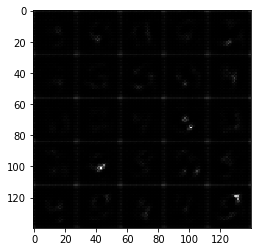

Epoch 0/2, D_loss: 1.5173, G_loss: 1.2289
Epoch 0/2, D_loss: 1.3497, G_loss: 1.3141
Epoch 0/2, D_loss: 1.5329, G_loss: 1.4924
Epoch 0/2, D_loss: 1.2890, G_loss: 1.3603
Epoch 0/2, D_loss: 1.3627, G_loss: 1.3777
Epoch 0/2, D_loss: 1.4819, G_loss: 1.2062
Epoch 0/2, D_loss: 1.4490, G_loss: 1.2477
Epoch 0/2, D_loss: 1.3828, G_loss: 1.4036
Epoch 0/2, D_loss: 1.1430, G_loss: 1.5763
Epoch 0/2, D_loss: 1.2512, G_loss: 1.5282


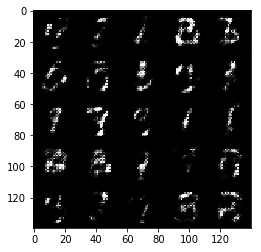

Epoch 0/2, D_loss: 1.4026, G_loss: 1.4161
Epoch 0/2, D_loss: 1.2217, G_loss: 1.7779
Epoch 0/2, D_loss: 1.2230, G_loss: 0.8511
Epoch 0/2, D_loss: 1.5938, G_loss: 0.3047
Epoch 0/2, D_loss: 1.6042, G_loss: 0.2874
Epoch 0/2, D_loss: 1.4229, G_loss: 0.4047
Epoch 0/2, D_loss: 1.0478, G_loss: 0.6836
Epoch 0/2, D_loss: 1.7054, G_loss: 1.7481
Epoch 0/2, D_loss: 1.1641, G_loss: 1.7143
Epoch 0/2, D_loss: 1.2543, G_loss: 0.9996


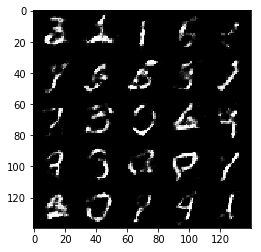

Epoch 0/2, D_loss: 1.3687, G_loss: 1.5843
Epoch 0/2, D_loss: 1.3628, G_loss: 1.1793
Epoch 0/2, D_loss: 1.3929, G_loss: 1.4371
Epoch 0/2, D_loss: 1.3549, G_loss: 0.8620
Epoch 0/2, D_loss: 1.4088, G_loss: 0.4329
Epoch 0/2, D_loss: 1.4592, G_loss: 0.3957
Epoch 0/2, D_loss: 1.4125, G_loss: 0.4290
Epoch 0/2, D_loss: 1.3410, G_loss: 0.4752
Epoch 0/2, D_loss: 1.4167, G_loss: 0.4607
Epoch 0/2, D_loss: 1.4269, G_loss: 0.4170


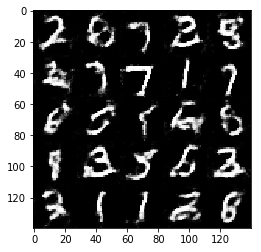

Epoch 0/2, D_loss: 1.2584, G_loss: 0.7010
Epoch 0/2, D_loss: 1.1113, G_loss: 1.2837
Epoch 0/2, D_loss: 1.3394, G_loss: 1.2272
Epoch 0/2, D_loss: 1.3383, G_loss: 0.9436
Epoch 0/2, D_loss: 1.3219, G_loss: 1.0617
Epoch 0/2, D_loss: 1.3242, G_loss: 0.9472
Epoch 1/2, D_loss: 1.4180, G_loss: 1.0910
Epoch 1/2, D_loss: 1.3366, G_loss: 0.8871
Epoch 1/2, D_loss: 1.4076, G_loss: 0.8449
Epoch 1/2, D_loss: 1.3930, G_loss: 1.1217


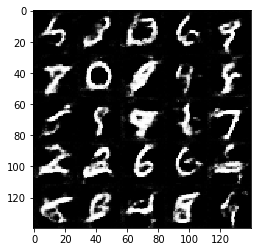

Epoch 1/2, D_loss: 1.2533, G_loss: 0.9668
Epoch 1/2, D_loss: 1.2710, G_loss: 0.9822
Epoch 1/2, D_loss: 1.4659, G_loss: 1.1350
Epoch 1/2, D_loss: 1.2498, G_loss: 1.0271
Epoch 1/2, D_loss: 1.4185, G_loss: 1.0988
Epoch 1/2, D_loss: 1.3003, G_loss: 1.0605
Epoch 1/2, D_loss: 1.3975, G_loss: 1.1801
Epoch 1/2, D_loss: 1.3501, G_loss: 1.0314
Epoch 1/2, D_loss: 1.2864, G_loss: 1.0399
Epoch 1/2, D_loss: 1.2775, G_loss: 1.0933


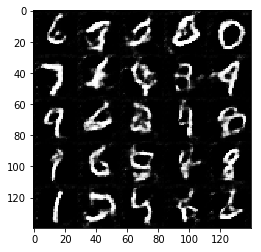

Epoch 1/2, D_loss: 1.2188, G_loss: 0.8748
Epoch 1/2, D_loss: 1.4590, G_loss: 0.3830
Epoch 1/2, D_loss: 1.4936, G_loss: 0.3821
Epoch 1/2, D_loss: 1.5120, G_loss: 0.3847
Epoch 1/2, D_loss: 1.4098, G_loss: 0.4639
Epoch 1/2, D_loss: 1.4493, G_loss: 0.4247
Epoch 1/2, D_loss: 1.2878, G_loss: 0.6320
Epoch 1/2, D_loss: 1.4832, G_loss: 0.3787
Epoch 1/2, D_loss: 1.4789, G_loss: 0.3707
Epoch 1/2, D_loss: 1.3951, G_loss: 0.4515


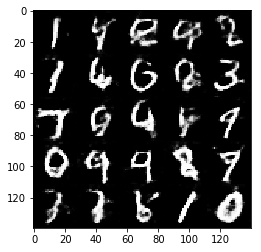

Epoch 1/2, D_loss: 1.3022, G_loss: 0.5197
Epoch 1/2, D_loss: 1.2806, G_loss: 0.5562
Epoch 1/2, D_loss: 1.4204, G_loss: 0.4240
Epoch 1/2, D_loss: 1.4396, G_loss: 0.4113
Epoch 1/2, D_loss: 1.3448, G_loss: 0.4771
Epoch 1/2, D_loss: 1.2849, G_loss: 0.5849
Epoch 1/2, D_loss: 1.3876, G_loss: 0.4538
Epoch 1/2, D_loss: 1.4324, G_loss: 0.4241
Epoch 1/2, D_loss: 1.3459, G_loss: 0.4611
Epoch 1/2, D_loss: 1.5449, G_loss: 0.3352


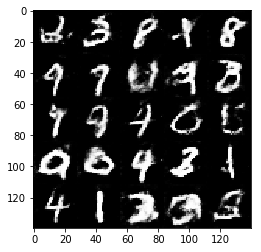

Epoch 1/2, D_loss: 1.3520, G_loss: 0.4551
Epoch 1/2, D_loss: 1.3920, G_loss: 0.4500
Epoch 1/2, D_loss: 1.4616, G_loss: 0.3794
Epoch 1/2, D_loss: 1.3777, G_loss: 0.4547
Epoch 1/2, D_loss: 1.2992, G_loss: 0.5228
Epoch 1/2, D_loss: 1.3700, G_loss: 0.4671
Epoch 1/2, D_loss: 1.2811, G_loss: 0.5575
Epoch 1/2, D_loss: 1.1536, G_loss: 0.8755
Epoch 1/2, D_loss: 1.4679, G_loss: 1.4113
Epoch 1/2, D_loss: 1.4533, G_loss: 1.2169


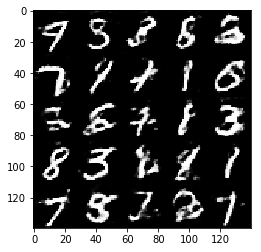

Epoch 1/2, D_loss: 1.3935, G_loss: 1.0116
Epoch 1/2, D_loss: 1.2795, G_loss: 1.0471
Epoch 1/2, D_loss: 1.3642, G_loss: 0.4621


In [33]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.01


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/3, D_loss: 5.5614, G_loss: 0.0044
Epoch 0/3, D_loss: 2.0665, G_loss: 0.1814
Epoch 0/3, D_loss: 4.7880, G_loss: 0.0111
Epoch 0/3, D_loss: 1.8896, G_loss: 0.2738
Epoch 0/3, D_loss: 1.6230, G_loss: 0.2901
Epoch 0/3, D_loss: 1.2039, G_loss: 0.4808
Epoch 0/3, D_loss: 2.5277, G_loss: 0.1009
Epoch 0/3, D_loss: 1.5749, G_loss: 0.2976
Epoch 0/3, D_loss: 0.9233, G_loss: 0.6049
Epoch 0/3, D_loss: 1.2419, G_loss: 0.5772


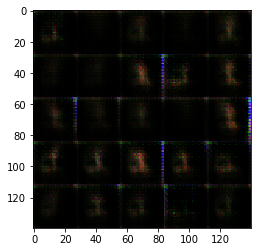

Epoch 0/3, D_loss: 1.6651, G_loss: 0.2746
Epoch 0/3, D_loss: 0.9477, G_loss: 0.6397
Epoch 0/3, D_loss: 1.9380, G_loss: 0.2310
Epoch 0/3, D_loss: 1.8285, G_loss: 0.2988
Epoch 0/3, D_loss: 1.5601, G_loss: 0.3578
Epoch 0/3, D_loss: 1.6374, G_loss: 0.3254
Epoch 0/3, D_loss: 1.4724, G_loss: 0.3653
Epoch 0/3, D_loss: 1.3022, G_loss: 0.6414
Epoch 0/3, D_loss: 1.4799, G_loss: 0.4123
Epoch 0/3, D_loss: 1.4677, G_loss: 0.3750


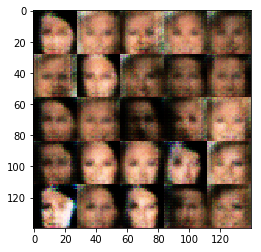

Epoch 0/3, D_loss: 1.5469, G_loss: 0.3909
Epoch 0/3, D_loss: 1.7661, G_loss: 0.2574
Epoch 0/3, D_loss: 1.3808, G_loss: 0.4392
Epoch 0/3, D_loss: 1.4535, G_loss: 0.3918
Epoch 0/3, D_loss: 1.3120, G_loss: 0.5229
Epoch 0/3, D_loss: 1.3544, G_loss: 0.4802
Epoch 0/3, D_loss: 1.2906, G_loss: 0.4804
Epoch 0/3, D_loss: 1.1539, G_loss: 0.6493
Epoch 0/3, D_loss: 1.7926, G_loss: 0.2557
Epoch 0/3, D_loss: 1.4452, G_loss: 0.3676


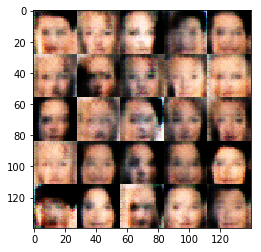

Epoch 0/3, D_loss: 1.4326, G_loss: 0.3835
Epoch 0/3, D_loss: 1.5335, G_loss: 0.3726
Epoch 0/3, D_loss: 1.4820, G_loss: 0.3798
Epoch 0/3, D_loss: 1.3863, G_loss: 0.5365
Epoch 0/3, D_loss: 1.6768, G_loss: 0.2944
Epoch 0/3, D_loss: 1.3341, G_loss: 0.5212
Epoch 0/3, D_loss: 1.4919, G_loss: 0.3542
Epoch 0/3, D_loss: 1.3551, G_loss: 0.4338
Epoch 0/3, D_loss: 1.5061, G_loss: 0.4676
Epoch 0/3, D_loss: 1.1807, G_loss: 0.6560


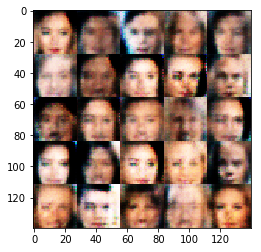

Epoch 0/3, D_loss: 1.5382, G_loss: 0.4745
Epoch 0/3, D_loss: 1.4087, G_loss: 0.4437
Epoch 0/3, D_loss: 1.3192, G_loss: 0.5381
Epoch 0/3, D_loss: 1.1776, G_loss: 0.7571
Epoch 0/3, D_loss: 1.6035, G_loss: 1.4103
Epoch 0/3, D_loss: 1.1107, G_loss: 0.6906
Epoch 0/3, D_loss: 1.3619, G_loss: 0.4909
Epoch 0/3, D_loss: 1.4133, G_loss: 0.4408
Epoch 0/3, D_loss: 1.5606, G_loss: 0.3492
Epoch 0/3, D_loss: 1.4721, G_loss: 0.4227


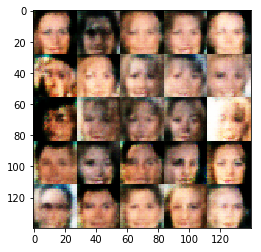

Epoch 0/3, D_loss: 1.4150, G_loss: 0.5214
Epoch 0/3, D_loss: 1.5117, G_loss: 0.3459
Epoch 0/3, D_loss: 1.4504, G_loss: 0.3506
Epoch 0/3, D_loss: 1.4715, G_loss: 0.4280
Epoch 0/3, D_loss: 1.2919, G_loss: 0.6726
Epoch 0/3, D_loss: 1.6644, G_loss: 0.2905
Epoch 0/3, D_loss: 1.2304, G_loss: 0.6926
Epoch 0/3, D_loss: 1.4537, G_loss: 0.5072
Epoch 0/3, D_loss: 1.4851, G_loss: 0.4972
Epoch 0/3, D_loss: 1.5953, G_loss: 0.3329


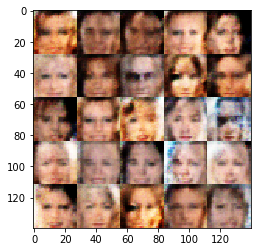

Epoch 0/3, D_loss: 1.1616, G_loss: 0.5536
Epoch 0/3, D_loss: 1.3341, G_loss: 0.4782
Epoch 0/3, D_loss: 1.4594, G_loss: 0.4162
Epoch 0/3, D_loss: 1.6703, G_loss: 0.2718
Epoch 0/3, D_loss: 1.2026, G_loss: 0.6574
Epoch 0/3, D_loss: 1.3491, G_loss: 0.5359
Epoch 0/3, D_loss: 1.3604, G_loss: 0.4900
Epoch 0/3, D_loss: 1.5068, G_loss: 0.4049
Epoch 0/3, D_loss: 1.5731, G_loss: 0.4289
Epoch 0/3, D_loss: 1.3056, G_loss: 0.6381


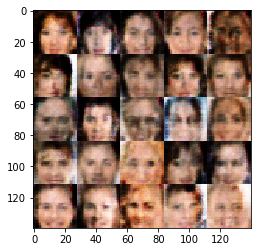

Epoch 0/3, D_loss: 1.6700, G_loss: 0.3425
Epoch 0/3, D_loss: 1.3612, G_loss: 0.6620
Epoch 0/3, D_loss: 1.2879, G_loss: 0.5599
Epoch 0/3, D_loss: 1.2370, G_loss: 0.6803
Epoch 0/3, D_loss: 1.3887, G_loss: 0.4752
Epoch 0/3, D_loss: 1.4861, G_loss: 0.4442
Epoch 0/3, D_loss: 1.1422, G_loss: 0.5499
Epoch 0/3, D_loss: 1.5153, G_loss: 0.5712
Epoch 0/3, D_loss: 1.1596, G_loss: 0.8333
Epoch 0/3, D_loss: 1.4045, G_loss: 1.0961


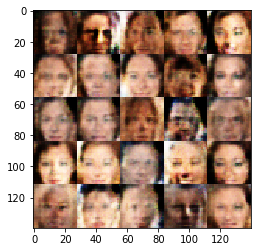

Epoch 0/3, D_loss: 1.3407, G_loss: 1.0321
Epoch 0/3, D_loss: 1.2241, G_loss: 1.4192
Epoch 0/3, D_loss: 1.5254, G_loss: 0.9662
Epoch 0/3, D_loss: 1.5673, G_loss: 0.3010
Epoch 0/3, D_loss: 1.3651, G_loss: 0.5112
Epoch 0/3, D_loss: 1.4493, G_loss: 0.5166
Epoch 0/3, D_loss: 1.1797, G_loss: 0.9222
Epoch 0/3, D_loss: 1.3259, G_loss: 0.8576
Epoch 0/3, D_loss: 1.3569, G_loss: 1.0597
Epoch 0/3, D_loss: 1.2116, G_loss: 0.7673


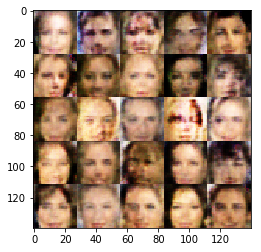

Epoch 0/3, D_loss: 1.2897, G_loss: 0.6521
Epoch 0/3, D_loss: 1.7755, G_loss: 1.5858
Epoch 0/3, D_loss: 1.1060, G_loss: 0.7178
Epoch 0/3, D_loss: 1.3674, G_loss: 0.7255
Epoch 0/3, D_loss: 1.4805, G_loss: 0.6246
Epoch 0/3, D_loss: 1.3707, G_loss: 0.6826
Epoch 0/3, D_loss: 1.3851, G_loss: 0.6405
Epoch 0/3, D_loss: 1.4185, G_loss: 0.5895
Epoch 0/3, D_loss: 1.7481, G_loss: 1.4225
Epoch 0/3, D_loss: 1.3920, G_loss: 0.8088


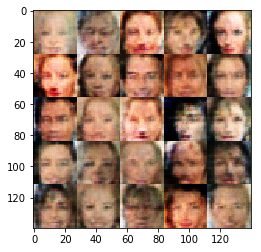

Epoch 0/3, D_loss: 1.3407, G_loss: 0.9910
Epoch 0/3, D_loss: 1.4953, G_loss: 0.9528
Epoch 0/3, D_loss: 1.4055, G_loss: 1.1949
Epoch 0/3, D_loss: 1.4321, G_loss: 1.2078
Epoch 0/3, D_loss: 1.2722, G_loss: 0.7751
Epoch 0/3, D_loss: 1.2561, G_loss: 0.8267
Epoch 0/3, D_loss: 1.2775, G_loss: 0.8379
Epoch 0/3, D_loss: 1.4382, G_loss: 0.3833
Epoch 0/3, D_loss: 1.4251, G_loss: 0.4484
Epoch 0/3, D_loss: 1.5066, G_loss: 0.3717


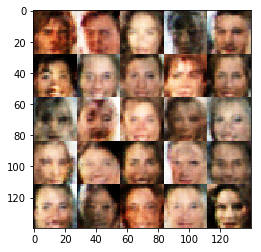

Epoch 0/3, D_loss: 1.3231, G_loss: 0.8270
Epoch 0/3, D_loss: 1.1995, G_loss: 1.1332
Epoch 0/3, D_loss: 1.3660, G_loss: 0.9942
Epoch 0/3, D_loss: 1.6168, G_loss: 1.3098
Epoch 0/3, D_loss: 1.3669, G_loss: 0.8328
Epoch 0/3, D_loss: 1.3714, G_loss: 0.9975
Epoch 0/3, D_loss: 1.5710, G_loss: 1.2201
Epoch 0/3, D_loss: 1.2651, G_loss: 0.9660
Epoch 0/3, D_loss: 1.4617, G_loss: 1.1490
Epoch 0/3, D_loss: 1.3802, G_loss: 0.8302


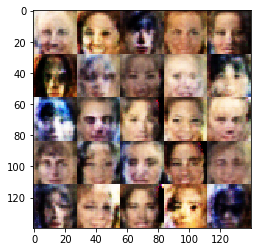

Epoch 0/3, D_loss: 1.2056, G_loss: 0.9681
Epoch 0/3, D_loss: 1.5099, G_loss: 0.4295
Epoch 0/3, D_loss: 1.2849, G_loss: 0.6055
Epoch 0/3, D_loss: 1.4293, G_loss: 0.4630
Epoch 0/3, D_loss: 1.3526, G_loss: 0.5278
Epoch 0/3, D_loss: 1.3288, G_loss: 0.5878
Epoch 0/3, D_loss: 1.3736, G_loss: 0.4458
Epoch 0/3, D_loss: 1.4624, G_loss: 0.4730
Epoch 0/3, D_loss: 1.3252, G_loss: 0.6023
Epoch 0/3, D_loss: 1.4592, G_loss: 0.5045


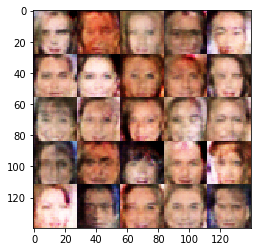

Epoch 0/3, D_loss: 1.0818, G_loss: 0.8768
Epoch 0/3, D_loss: 1.3831, G_loss: 1.0162
Epoch 0/3, D_loss: 1.4629, G_loss: 1.0481
Epoch 0/3, D_loss: 1.3732, G_loss: 1.1595
Epoch 0/3, D_loss: 1.6033, G_loss: 1.3604
Epoch 0/3, D_loss: 1.4270, G_loss: 0.6946
Epoch 0/3, D_loss: 1.3640, G_loss: 0.4911
Epoch 0/3, D_loss: 1.4860, G_loss: 0.4219
Epoch 0/3, D_loss: 1.3994, G_loss: 0.9308
Epoch 0/3, D_loss: 1.2501, G_loss: 0.7810


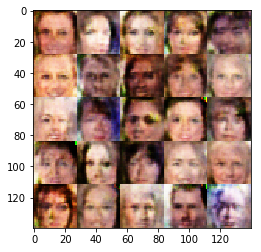

Epoch 0/3, D_loss: 1.4306, G_loss: 0.6424
Epoch 0/3, D_loss: 1.3418, G_loss: 0.5030
Epoch 0/3, D_loss: 1.5983, G_loss: 0.4662
Epoch 0/3, D_loss: 1.3362, G_loss: 0.7162
Epoch 0/3, D_loss: 1.3409, G_loss: 0.8002
Epoch 0/3, D_loss: 1.3418, G_loss: 1.0174
Epoch 0/3, D_loss: 1.4294, G_loss: 0.9614
Epoch 0/3, D_loss: 1.3352, G_loss: 0.9260
Epoch 0/3, D_loss: 1.3582, G_loss: 0.9030
Epoch 0/3, D_loss: 1.3484, G_loss: 0.9581


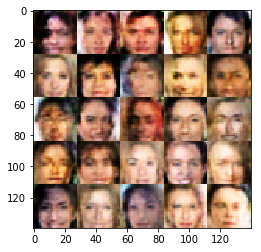

Epoch 0/3, D_loss: 1.2599, G_loss: 0.7894
Epoch 0/3, D_loss: 1.2492, G_loss: 0.7078
Epoch 0/3, D_loss: 1.2589, G_loss: 0.8054
Epoch 0/3, D_loss: 1.4937, G_loss: 1.2220
Epoch 0/3, D_loss: 1.3387, G_loss: 1.0416
Epoch 0/3, D_loss: 1.3368, G_loss: 0.8349
Epoch 0/3, D_loss: 1.1828, G_loss: 0.8517
Epoch 0/3, D_loss: 1.4840, G_loss: 0.9316
Epoch 1/3, D_loss: 1.4210, G_loss: 0.6956
Epoch 1/3, D_loss: 1.3182, G_loss: 0.8076


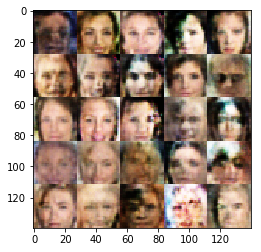

Epoch 1/3, D_loss: 1.0982, G_loss: 1.2518
Epoch 1/3, D_loss: 1.3493, G_loss: 0.7975
Epoch 1/3, D_loss: 1.4629, G_loss: 0.4705
Epoch 1/3, D_loss: 1.3612, G_loss: 0.6119
Epoch 1/3, D_loss: 1.3482, G_loss: 0.6194
Epoch 1/3, D_loss: 1.3268, G_loss: 0.7919
Epoch 1/3, D_loss: 1.4020, G_loss: 0.6502
Epoch 1/3, D_loss: 1.4420, G_loss: 0.4135
Epoch 1/3, D_loss: 1.4228, G_loss: 0.4987
Epoch 1/3, D_loss: 1.2770, G_loss: 0.6128


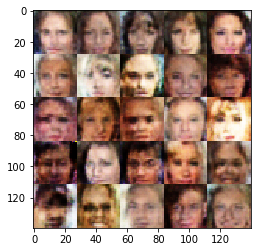

Epoch 1/3, D_loss: 1.3721, G_loss: 0.5076
Epoch 1/3, D_loss: 1.3708, G_loss: 0.6002
Epoch 1/3, D_loss: 1.3799, G_loss: 0.6089
Epoch 1/3, D_loss: 1.3992, G_loss: 0.6602
Epoch 1/3, D_loss: 1.4750, G_loss: 1.0920
Epoch 1/3, D_loss: 1.2211, G_loss: 0.7975
Epoch 1/3, D_loss: 1.3928, G_loss: 0.8901
Epoch 1/3, D_loss: 1.4290, G_loss: 0.9575
Epoch 1/3, D_loss: 1.3706, G_loss: 0.7159
Epoch 1/3, D_loss: 1.2846, G_loss: 1.1562


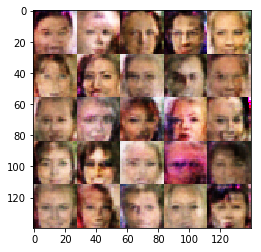

Epoch 1/3, D_loss: 1.3568, G_loss: 1.0481
Epoch 1/3, D_loss: 1.4411, G_loss: 0.7962
Epoch 1/3, D_loss: 1.4218, G_loss: 0.8284
Epoch 1/3, D_loss: 1.2049, G_loss: 1.1190
Epoch 1/3, D_loss: 1.3113, G_loss: 0.8941
Epoch 1/3, D_loss: 1.4239, G_loss: 1.1621
Epoch 1/3, D_loss: 1.3710, G_loss: 1.0107
Epoch 1/3, D_loss: 1.1864, G_loss: 0.8890
Epoch 1/3, D_loss: 1.3410, G_loss: 0.9936
Epoch 1/3, D_loss: 1.4708, G_loss: 1.0520


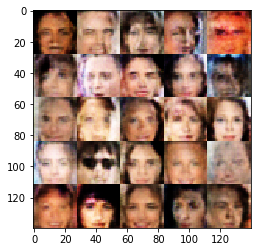

Epoch 1/3, D_loss: 1.1515, G_loss: 1.1272
Epoch 1/3, D_loss: 1.3377, G_loss: 0.8312
Epoch 1/3, D_loss: 1.3688, G_loss: 0.7346
Epoch 1/3, D_loss: 1.3989, G_loss: 0.5158
Epoch 1/3, D_loss: 1.4233, G_loss: 0.5050
Epoch 1/3, D_loss: 1.2686, G_loss: 0.5504
Epoch 1/3, D_loss: 1.2868, G_loss: 0.7736
Epoch 1/3, D_loss: 1.2809, G_loss: 0.7912
Epoch 1/3, D_loss: 1.3304, G_loss: 1.1476
Epoch 1/3, D_loss: 1.3889, G_loss: 0.7612


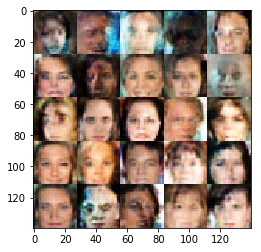

Epoch 1/3, D_loss: 1.0739, G_loss: 0.5987
Epoch 1/3, D_loss: 1.4430, G_loss: 0.4291
Epoch 1/3, D_loss: 1.4840, G_loss: 0.3820
Epoch 1/3, D_loss: 1.4719, G_loss: 0.4160
Epoch 1/3, D_loss: 1.3886, G_loss: 0.4903
Epoch 1/3, D_loss: 1.4513, G_loss: 0.4698
Epoch 1/3, D_loss: 1.5039, G_loss: 0.4032
Epoch 1/3, D_loss: 1.3881, G_loss: 0.4961
Epoch 1/3, D_loss: 1.6133, G_loss: 0.2927
Epoch 1/3, D_loss: 1.3240, G_loss: 0.7435


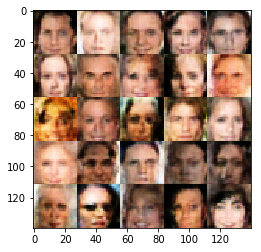

Epoch 1/3, D_loss: 1.3543, G_loss: 0.8629
Epoch 1/3, D_loss: 1.2250, G_loss: 1.1751
Epoch 1/3, D_loss: 1.3649, G_loss: 0.8418
Epoch 1/3, D_loss: 1.4676, G_loss: 1.0065
Epoch 1/3, D_loss: 1.4317, G_loss: 1.1520
Epoch 1/3, D_loss: 1.2982, G_loss: 0.7655
Epoch 1/3, D_loss: 1.3790, G_loss: 0.4597
Epoch 1/3, D_loss: 1.2090, G_loss: 0.7195
Epoch 1/3, D_loss: 1.3630, G_loss: 0.5457
Epoch 1/3, D_loss: 1.3972, G_loss: 0.4891


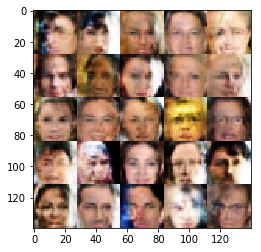

Epoch 1/3, D_loss: 1.3793, G_loss: 0.4972
Epoch 1/3, D_loss: 1.3993, G_loss: 0.6049
Epoch 1/3, D_loss: 1.3300, G_loss: 0.5277
Epoch 1/3, D_loss: 1.3653, G_loss: 0.5299
Epoch 1/3, D_loss: 1.3652, G_loss: 1.0712
Epoch 1/3, D_loss: 1.3550, G_loss: 0.5959
Epoch 1/3, D_loss: 1.4142, G_loss: 1.0845
Epoch 1/3, D_loss: 1.3720, G_loss: 0.7643
Epoch 1/3, D_loss: 1.3750, G_loss: 0.8770
Epoch 1/3, D_loss: 1.3667, G_loss: 0.5642


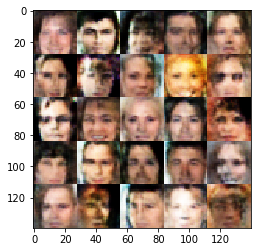

Epoch 1/3, D_loss: 1.4220, G_loss: 0.5332
Epoch 1/3, D_loss: 1.3984, G_loss: 0.5595
Epoch 1/3, D_loss: 0.9586, G_loss: 0.9872
Epoch 1/3, D_loss: 1.3811, G_loss: 0.7819
Epoch 1/3, D_loss: 1.5659, G_loss: 1.2987
Epoch 1/3, D_loss: 1.4502, G_loss: 0.5202
Epoch 1/3, D_loss: 1.4640, G_loss: 0.4340
Epoch 1/3, D_loss: 1.2426, G_loss: 0.6611
Epoch 1/3, D_loss: 1.3734, G_loss: 0.5394
Epoch 1/3, D_loss: 1.3420, G_loss: 0.6601


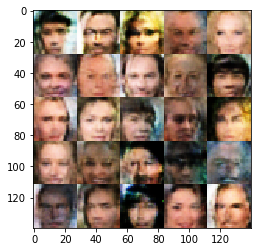

Epoch 1/3, D_loss: 1.0322, G_loss: 1.3718
Epoch 1/3, D_loss: 1.3048, G_loss: 0.9191
Epoch 1/3, D_loss: 1.4575, G_loss: 1.1000
Epoch 1/3, D_loss: 1.2365, G_loss: 1.0218
Epoch 1/3, D_loss: 1.3432, G_loss: 0.7684
Epoch 1/3, D_loss: 1.3484, G_loss: 0.8740
Epoch 1/3, D_loss: 1.3860, G_loss: 0.7180
Epoch 1/3, D_loss: 1.4517, G_loss: 1.2443
Epoch 1/3, D_loss: 1.2782, G_loss: 0.9137
Epoch 1/3, D_loss: 1.1572, G_loss: 0.9097


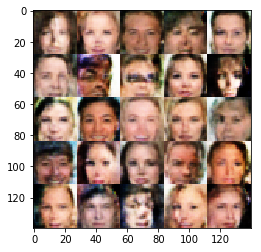

Epoch 1/3, D_loss: 1.1353, G_loss: 0.8179
Epoch 1/3, D_loss: 1.3908, G_loss: 0.5287
Epoch 1/3, D_loss: 1.5275, G_loss: 0.5802
Epoch 1/3, D_loss: 1.4190, G_loss: 0.4544
Epoch 1/3, D_loss: 1.4511, G_loss: 0.4237
Epoch 1/3, D_loss: 1.2059, G_loss: 0.5938
Epoch 1/3, D_loss: 1.3588, G_loss: 0.5242
Epoch 1/3, D_loss: 1.4881, G_loss: 1.0735
Epoch 1/3, D_loss: 1.4027, G_loss: 0.9520
Epoch 1/3, D_loss: 1.2925, G_loss: 0.5658


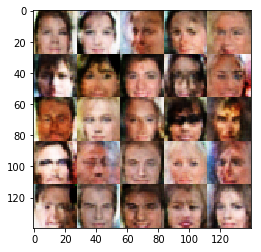

Epoch 1/3, D_loss: 1.4386, G_loss: 0.4981
Epoch 1/3, D_loss: 1.3525, G_loss: 0.5137
Epoch 1/3, D_loss: 1.4303, G_loss: 0.4509
Epoch 1/3, D_loss: 1.3512, G_loss: 0.4724
Epoch 1/3, D_loss: 1.3646, G_loss: 0.5362
Epoch 1/3, D_loss: 1.4701, G_loss: 0.4582
Epoch 1/3, D_loss: 1.4240, G_loss: 0.5308
Epoch 1/3, D_loss: 1.3740, G_loss: 0.5931
Epoch 1/3, D_loss: 1.2096, G_loss: 0.6211
Epoch 1/3, D_loss: 1.4447, G_loss: 1.0138


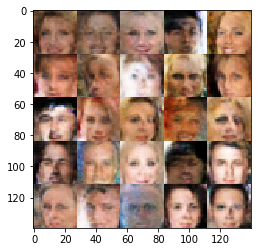

Epoch 1/3, D_loss: 1.2645, G_loss: 0.8525
Epoch 1/3, D_loss: 1.3197, G_loss: 0.9585
Epoch 1/3, D_loss: 1.3719, G_loss: 0.9271
Epoch 1/3, D_loss: 1.3640, G_loss: 0.7424
Epoch 1/3, D_loss: 1.4158, G_loss: 1.0912
Epoch 1/3, D_loss: 1.3116, G_loss: 0.6373
Epoch 1/3, D_loss: 1.3380, G_loss: 0.6296
Epoch 1/3, D_loss: 1.7398, G_loss: 1.6123
Epoch 1/3, D_loss: 1.4701, G_loss: 0.4180
Epoch 1/3, D_loss: 1.3529, G_loss: 0.4727


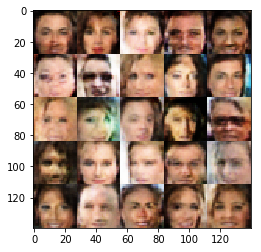

Epoch 1/3, D_loss: 1.3677, G_loss: 0.5199
Epoch 1/3, D_loss: 1.3394, G_loss: 0.5297
Epoch 1/3, D_loss: 1.2799, G_loss: 0.5706
Epoch 1/3, D_loss: 1.4010, G_loss: 1.1712
Epoch 1/3, D_loss: 1.2595, G_loss: 0.8868
Epoch 1/3, D_loss: 1.3643, G_loss: 0.7450
Epoch 1/3, D_loss: 1.5610, G_loss: 1.3707
Epoch 1/3, D_loss: 1.2987, G_loss: 0.9221
Epoch 1/3, D_loss: 1.3505, G_loss: 1.2105
Epoch 1/3, D_loss: 1.2125, G_loss: 0.9108


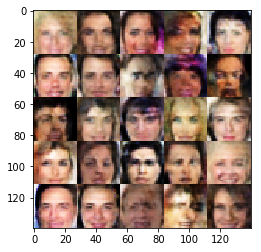

Epoch 1/3, D_loss: 1.4086, G_loss: 0.9562
Epoch 1/3, D_loss: 1.3766, G_loss: 0.8024
Epoch 1/3, D_loss: 1.3573, G_loss: 0.9010
Epoch 1/3, D_loss: 1.3286, G_loss: 1.0093
Epoch 1/3, D_loss: 1.3784, G_loss: 1.0049
Epoch 1/3, D_loss: 1.5314, G_loss: 1.1541
Epoch 1/3, D_loss: 1.2675, G_loss: 0.9855
Epoch 1/3, D_loss: 1.4295, G_loss: 1.1157
Epoch 1/3, D_loss: 1.2952, G_loss: 0.8205
Epoch 1/3, D_loss: 1.3168, G_loss: 0.5375


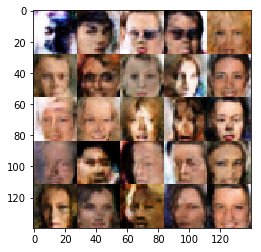

Epoch 1/3, D_loss: 1.3316, G_loss: 0.5659
Epoch 1/3, D_loss: 1.3266, G_loss: 0.6420
Epoch 1/3, D_loss: 1.3554, G_loss: 1.0179
Epoch 1/3, D_loss: 1.3397, G_loss: 0.9355
Epoch 1/3, D_loss: 1.3607, G_loss: 0.9065
Epoch 1/3, D_loss: 1.2106, G_loss: 0.6574
Epoch 1/3, D_loss: 1.4309, G_loss: 0.5132
Epoch 1/3, D_loss: 1.3722, G_loss: 0.5462
Epoch 1/3, D_loss: 1.3336, G_loss: 0.7871
Epoch 1/3, D_loss: 1.3160, G_loss: 0.8971


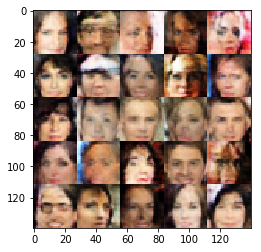

Epoch 1/3, D_loss: 1.3926, G_loss: 1.0281
Epoch 1/3, D_loss: 1.4122, G_loss: 0.9841
Epoch 1/3, D_loss: 1.3004, G_loss: 0.6813
Epoch 1/3, D_loss: 1.3748, G_loss: 0.9935
Epoch 1/3, D_loss: 1.4046, G_loss: 0.7603
Epoch 1/3, D_loss: 1.4812, G_loss: 1.0536
Epoch 2/3, D_loss: 1.4170, G_loss: 0.9382
Epoch 2/3, D_loss: 1.4064, G_loss: 0.6003
Epoch 2/3, D_loss: 1.4404, G_loss: 0.9026
Epoch 2/3, D_loss: 1.4126, G_loss: 0.9148


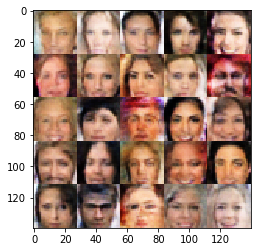

Epoch 2/3, D_loss: 1.3329, G_loss: 0.6248
Epoch 2/3, D_loss: 1.2609, G_loss: 0.7236
Epoch 2/3, D_loss: 1.4118, G_loss: 0.5299
Epoch 2/3, D_loss: 1.5132, G_loss: 0.3814
Epoch 2/3, D_loss: 1.4482, G_loss: 0.4319
Epoch 2/3, D_loss: 1.4121, G_loss: 0.4684
Epoch 2/3, D_loss: 1.0609, G_loss: 0.7273
Epoch 2/3, D_loss: 1.4009, G_loss: 0.6165
Epoch 2/3, D_loss: 1.3953, G_loss: 0.4808
Epoch 2/3, D_loss: 1.3648, G_loss: 0.4472


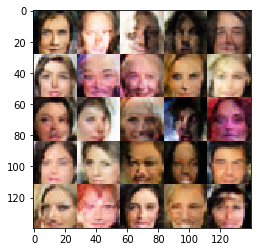

Epoch 2/3, D_loss: 1.3581, G_loss: 0.5326
Epoch 2/3, D_loss: 1.5957, G_loss: 0.3502
Epoch 2/3, D_loss: 1.3000, G_loss: 0.6646
Epoch 2/3, D_loss: 1.4306, G_loss: 0.9528
Epoch 2/3, D_loss: 1.2721, G_loss: 0.7936
Epoch 2/3, D_loss: 1.3447, G_loss: 0.5630
Epoch 2/3, D_loss: 1.4721, G_loss: 1.2567
Epoch 2/3, D_loss: 1.4231, G_loss: 1.1562
Epoch 2/3, D_loss: 1.2971, G_loss: 0.7371
Epoch 2/3, D_loss: 1.4588, G_loss: 0.8848


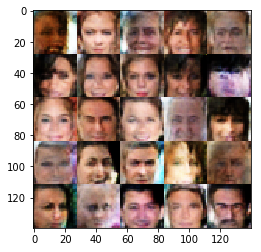

Epoch 2/3, D_loss: 1.4500, G_loss: 0.7125
Epoch 2/3, D_loss: 1.4255, G_loss: 0.4104
Epoch 2/3, D_loss: 1.4800, G_loss: 0.4136
Epoch 2/3, D_loss: 1.3271, G_loss: 0.5404
Epoch 2/3, D_loss: 1.4212, G_loss: 0.4607
Epoch 2/3, D_loss: 1.6762, G_loss: 0.3297
Epoch 2/3, D_loss: 1.2958, G_loss: 0.7105
Epoch 2/3, D_loss: 1.4088, G_loss: 0.6028
Epoch 2/3, D_loss: 1.4368, G_loss: 0.4568
Epoch 2/3, D_loss: 1.3758, G_loss: 0.5479


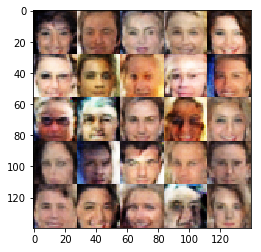

Epoch 2/3, D_loss: 1.4646, G_loss: 0.4397
Epoch 2/3, D_loss: 1.3486, G_loss: 0.5269
Epoch 2/3, D_loss: 1.2550, G_loss: 0.6795
Epoch 2/3, D_loss: 1.4228, G_loss: 0.4731
Epoch 2/3, D_loss: 1.4391, G_loss: 0.5771
Epoch 2/3, D_loss: 1.4608, G_loss: 0.4320
Epoch 2/3, D_loss: 1.3697, G_loss: 0.6330
Epoch 2/3, D_loss: 1.5595, G_loss: 0.3551
Epoch 2/3, D_loss: 1.3215, G_loss: 0.5284
Epoch 2/3, D_loss: 1.3539, G_loss: 0.4420


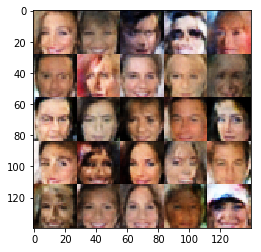

Epoch 2/3, D_loss: 1.3555, G_loss: 0.5637
Epoch 2/3, D_loss: 1.3014, G_loss: 0.7490
Epoch 2/3, D_loss: 1.4397, G_loss: 0.4292
Epoch 2/3, D_loss: 1.3837, G_loss: 0.4953
Epoch 2/3, D_loss: 1.4218, G_loss: 0.4839
Epoch 2/3, D_loss: 1.3181, G_loss: 0.5543
Epoch 2/3, D_loss: 1.3341, G_loss: 0.6258
Epoch 2/3, D_loss: 1.3542, G_loss: 0.6240
Epoch 2/3, D_loss: 1.3144, G_loss: 1.0009
Epoch 2/3, D_loss: 1.3573, G_loss: 0.9123


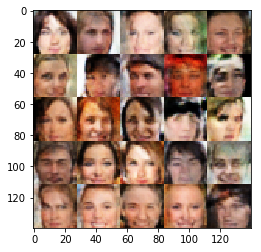

Epoch 2/3, D_loss: 1.2542, G_loss: 0.7339
Epoch 2/3, D_loss: 1.3330, G_loss: 0.7864
Epoch 2/3, D_loss: 1.2648, G_loss: 0.8460
Epoch 2/3, D_loss: 1.3113, G_loss: 0.8898
Epoch 2/3, D_loss: 1.2122, G_loss: 0.7873
Epoch 2/3, D_loss: 1.4518, G_loss: 0.4416
Epoch 2/3, D_loss: 1.2910, G_loss: 0.5345
Epoch 2/3, D_loss: 1.3957, G_loss: 0.4422
Epoch 2/3, D_loss: 1.4045, G_loss: 0.4661
Epoch 2/3, D_loss: 1.3674, G_loss: 0.4894


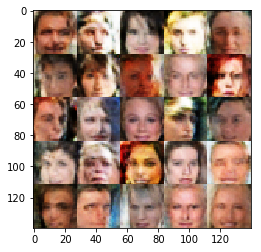

Epoch 2/3, D_loss: 1.3045, G_loss: 0.5407
Epoch 2/3, D_loss: 1.3393, G_loss: 0.5686
Epoch 2/3, D_loss: 1.3844, G_loss: 0.5289
Epoch 2/3, D_loss: 1.4365, G_loss: 0.4691
Epoch 2/3, D_loss: 1.3548, G_loss: 0.5035
Epoch 2/3, D_loss: 1.2101, G_loss: 0.6474
Epoch 2/3, D_loss: 1.3168, G_loss: 0.6920
Epoch 2/3, D_loss: 1.3981, G_loss: 0.5825
Epoch 2/3, D_loss: 1.4968, G_loss: 0.4061
Epoch 2/3, D_loss: 1.3970, G_loss: 0.4660


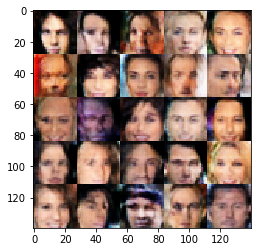

Epoch 2/3, D_loss: 1.3966, G_loss: 0.4597
Epoch 2/3, D_loss: 1.3422, G_loss: 0.5365
Epoch 2/3, D_loss: 1.1707, G_loss: 0.7783
Epoch 2/3, D_loss: 1.3673, G_loss: 0.5142
Epoch 2/3, D_loss: 1.3495, G_loss: 0.5267
Epoch 2/3, D_loss: 1.3294, G_loss: 1.0159
Epoch 2/3, D_loss: 1.4011, G_loss: 1.1420
Epoch 2/3, D_loss: 1.3829, G_loss: 0.7012
Epoch 2/3, D_loss: 1.2949, G_loss: 0.6057
Epoch 2/3, D_loss: 1.4744, G_loss: 0.4032


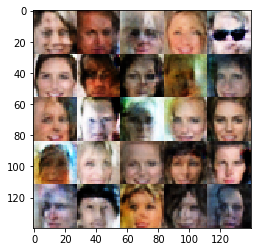

Epoch 2/3, D_loss: 1.3617, G_loss: 0.5058
Epoch 2/3, D_loss: 1.3686, G_loss: 0.5382
Epoch 2/3, D_loss: 1.2947, G_loss: 0.6982
Epoch 2/3, D_loss: 1.4457, G_loss: 0.5663
Epoch 2/3, D_loss: 1.3549, G_loss: 1.0732
Epoch 2/3, D_loss: 1.1619, G_loss: 0.9093
Epoch 2/3, D_loss: 1.4552, G_loss: 1.2123
Epoch 2/3, D_loss: 1.2588, G_loss: 1.0519
Epoch 2/3, D_loss: 1.3409, G_loss: 0.8985
Epoch 2/3, D_loss: 1.3216, G_loss: 0.7976


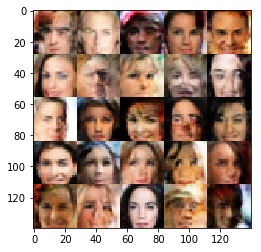

Epoch 2/3, D_loss: 1.2315, G_loss: 0.8385
Epoch 2/3, D_loss: 1.3913, G_loss: 0.4999
Epoch 2/3, D_loss: 1.2282, G_loss: 0.7489
Epoch 2/3, D_loss: 1.5193, G_loss: 1.1855
Epoch 2/3, D_loss: 1.4041, G_loss: 0.4642
Epoch 2/3, D_loss: 1.2957, G_loss: 0.6276
Epoch 2/3, D_loss: 1.4205, G_loss: 0.4632
Epoch 2/3, D_loss: 1.3652, G_loss: 0.4628
Epoch 2/3, D_loss: 1.3627, G_loss: 0.4725
Epoch 2/3, D_loss: 1.2581, G_loss: 0.7112


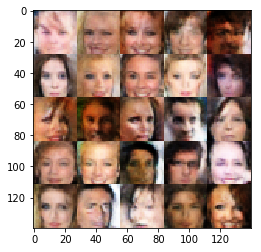

Epoch 2/3, D_loss: 1.2277, G_loss: 0.6795
Epoch 2/3, D_loss: 1.4124, G_loss: 0.5003
Epoch 2/3, D_loss: 1.4220, G_loss: 0.4470
Epoch 2/3, D_loss: 1.4360, G_loss: 0.4160
Epoch 2/3, D_loss: 1.2993, G_loss: 0.5362
Epoch 2/3, D_loss: 1.3850, G_loss: 0.4526
Epoch 2/3, D_loss: 1.3445, G_loss: 0.4808
Epoch 2/3, D_loss: 1.2059, G_loss: 0.7606
Epoch 2/3, D_loss: 1.3191, G_loss: 0.8353
Epoch 2/3, D_loss: 1.4023, G_loss: 1.0208


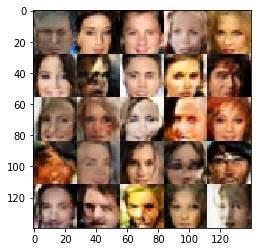

Epoch 2/3, D_loss: 1.5723, G_loss: 0.3488
Epoch 2/3, D_loss: 1.3350, G_loss: 0.4975
Epoch 2/3, D_loss: 1.2638, G_loss: 0.6519
Epoch 2/3, D_loss: 1.4355, G_loss: 0.4310
Epoch 2/3, D_loss: 1.3534, G_loss: 0.4894
Epoch 2/3, D_loss: 1.3737, G_loss: 1.0840
Epoch 2/3, D_loss: 1.4017, G_loss: 0.9108
Epoch 2/3, D_loss: 1.3155, G_loss: 0.8808
Epoch 2/3, D_loss: 1.2634, G_loss: 0.7869
Epoch 2/3, D_loss: 1.3503, G_loss: 0.6910


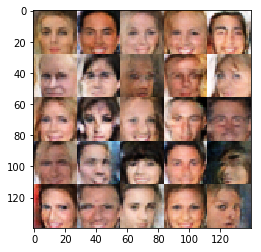

Epoch 2/3, D_loss: 1.4515, G_loss: 0.4468
Epoch 2/3, D_loss: 1.3303, G_loss: 0.9797
Epoch 2/3, D_loss: 1.1836, G_loss: 0.7581
Epoch 2/3, D_loss: 1.5117, G_loss: 0.4142
Epoch 2/3, D_loss: 1.3692, G_loss: 0.8271
Epoch 2/3, D_loss: 1.2963, G_loss: 0.6728
Epoch 2/3, D_loss: 1.3828, G_loss: 0.4915
Epoch 2/3, D_loss: 1.2840, G_loss: 0.6028
Epoch 2/3, D_loss: 1.2483, G_loss: 0.9708
Epoch 2/3, D_loss: 1.2847, G_loss: 0.9209


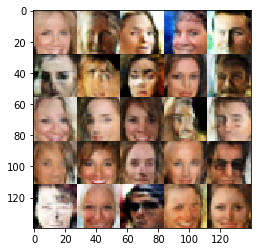

Epoch 2/3, D_loss: 1.2855, G_loss: 0.9031
Epoch 2/3, D_loss: 1.3746, G_loss: 0.8330
Epoch 2/3, D_loss: 1.2811, G_loss: 0.8207
Epoch 2/3, D_loss: 1.3742, G_loss: 0.7979
Epoch 2/3, D_loss: 1.3466, G_loss: 0.9245
Epoch 2/3, D_loss: 1.2287, G_loss: 0.7949
Epoch 2/3, D_loss: 1.2918, G_loss: 1.0496
Epoch 2/3, D_loss: 1.3156, G_loss: 0.9522
Epoch 2/3, D_loss: 1.2173, G_loss: 0.7734
Epoch 2/3, D_loss: 1.3778, G_loss: 0.4414


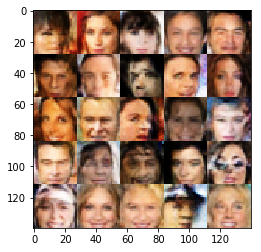

Epoch 2/3, D_loss: 1.4432, G_loss: 0.4700
Epoch 2/3, D_loss: 1.3707, G_loss: 0.5615
Epoch 2/3, D_loss: 1.3313, G_loss: 0.7710
Epoch 2/3, D_loss: 1.4474, G_loss: 0.9711
Epoch 2/3, D_loss: 1.3572, G_loss: 0.7195
Epoch 2/3, D_loss: 1.4549, G_loss: 0.4231
Epoch 2/3, D_loss: 1.2811, G_loss: 0.5670
Epoch 2/3, D_loss: 1.3440, G_loss: 0.5185
Epoch 2/3, D_loss: 1.3203, G_loss: 0.5499
Epoch 2/3, D_loss: 1.2808, G_loss: 0.7979


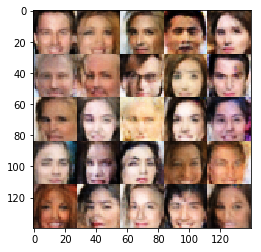

Epoch 2/3, D_loss: 1.3222, G_loss: 1.1247
Epoch 2/3, D_loss: 1.3837, G_loss: 0.7833
Epoch 2/3, D_loss: 1.2856, G_loss: 0.7549
Epoch 2/3, D_loss: 1.5684, G_loss: 1.2264


In [36]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.01


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.